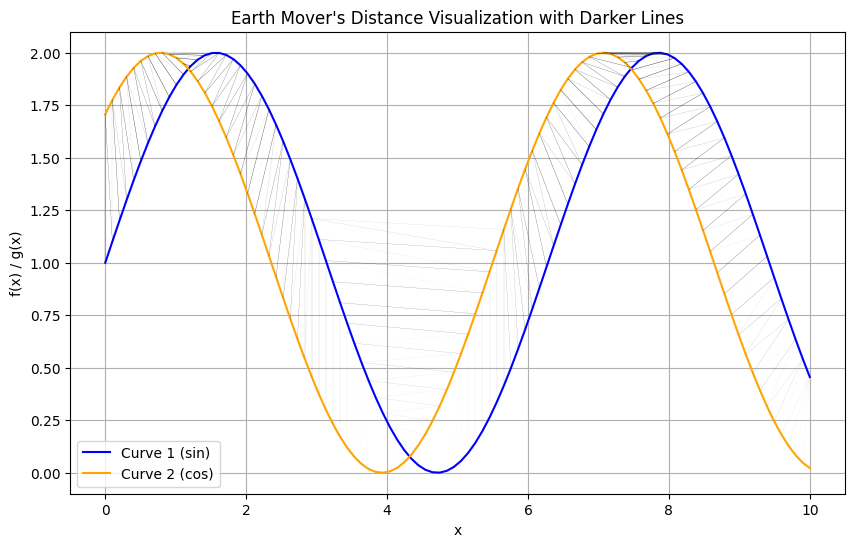

Earth Mover's Distance (EMD): 0.5991371868362699


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

# Step 1: Define the curves
x = np.linspace(0, 10, 100)  # Create 100 evenly spaced points in the range [0, 10]
curve1 = np.sin(x) + 1  # Define the first curve (shifted sine wave to ensure non-negative values)
x1 = np.linspace(0, 10, 100)  # Create 100 evenly spaced points in the range [0, 10]
curve2 = np.cos(x1-np.pi/4) + 1  # Define the second curve (shifted cosine wave to ensure non-negative values)

# Step 2: Sample points and assign weights
points1 = np.column_stack([x, curve1])  # Combine x-coordinates and curve1 values into (x, f(x)) pairs
points2 = np.column_stack([x, curve2])  # Combine x-coordinates and curve2 values into (x, g(x)) pairs
weights1 = curve1 / np.sum(curve1)  # Normalize the weights for curve1 so that they sum to 1
weights2 = curve2 / np.sum(curve2)  # Normalize the weights for curve2 so that they sum to 1

# Step 3: Compute pairwise distances (cost matrix)
# This matrix contains the Euclidean distances between every pair of points from curve1 and curve2
cost_matrix = np.linalg.norm(points1[:, None, :] - points2[None, :, :], axis=2)

# Step 4: Solve the optimal transport problem using linear programming
num_points1 = len(points1)  # Number of points in curve1
num_points2 = len(points2)  # Number of points in curve2

# Linear programming requires the cost matrix to be flattened
flow_result = linprog(
    c=cost_matrix.ravel(),  # Flatten the cost matrix into a 1D array
    A_eq=np.vstack([
        np.repeat(np.eye(num_points1), num_points2, axis=1),  # Flow conservation for curve1
        np.tile(np.eye(num_points2), (1, num_points1)),       # Flow conservation for curve2
    ]),
    b_eq=np.hstack([weights1, weights2]),  # The total flow must equal the weights
    bounds=(0, None),  # Flows cannot be negative
    method="highs"  # High-performance solver
)

# Step 5: Extract the optimal flow matrix
flow_matrix = flow_result.x.reshape(cost_matrix.shape)  # Reshape the solution back to the shape of the cost matrix

# Step 6: Visualize the curves and transport flows
fig, ax = plt.subplots(figsize=(10, 6))

# Plot curve1
ax.plot(x, curve1, label="Curve 1 (sin)", color="blue")
# Plot curve2
ax.plot(x, curve2, label="Curve 2 (cos)", color="orange")

# Plot the transport flows between the two curves
for i in range(num_points1):
    for j in range(num_points2):
        if flow_matrix[i, j] > 1e-4:  # Visualize only significant flows
            ax.plot(
                [points1[i, 0], points2[j, 0]],  # x-coordinates of the flow line
                [points1[i, 1], points2[j, 1]],  # y-coordinates of the flow line
                color="black", alpha=0.8, linewidth=flow_matrix[i, j] * 20  # Line thickness proportional to flow
            )


ax.set_title("Earth Mover's Distance Visualization with Darker Lines")
ax.set_xlabel("x")
ax.set_ylabel("f(x) / g(x)")
ax.legend()
plt.grid(True)
plt.show()


emd = np.sum(flow_matrix * cost_matrix)  # Total cost of transporting mass
print("Earth Mover's Distance (EMD):", emd)


In [41]:


def calculate_emd(points1, points2, weights1=None, weights2=None, plot=True):
    """
    Calculate the Earth Mover's Distance (EMD) between two sets of points with possibly unequal sizes.

    Args:
        points1 (list of tuples): List of (x, y) coordinates for set 1.
        points2 (list of tuples): List of (x, y) coordinates for set 2.
        weights1 (list, optional): Weights for set 1 points. Defaults to uniform.
        weights2 (list, optional): Weights for set 2 points. Defaults to uniform.
        plot (bool): Whether to visualize the transport flows.

    Returns:
        float: The Earth Mover's Distance (EMD).
    """
    # Convert points to NumPy arrays
    points1 = np.array(points1)
    points2 = np.array(points2)
    num_points1 = len(points1)
    num_points2 = len(points2)

    # Assign uniform weights if not provided
    if weights1 is None:
        weights1 = np.ones(num_points1) / num_points1
    if weights2 is None:
        weights2 = np.ones(num_points2) / num_points2

    # Normalize weights to ensure they sum to 1
    weights1 = weights1 / np.sum(weights1)
    weights2 = weights2 / np.sum(weights2)

    # Compute pairwise cost (Euclidean distances)
    cost_matrix = np.linalg.norm(points1[:, None, :] - points2[None, :, :], axis=2)

    # Solve the optimal transport problem
    flow_result = linprog(
        c=cost_matrix.ravel(),  # Flatten the cost matrix
        A_eq=np.vstack([
            np.repeat(np.eye(num_points1), num_points2, axis=1),  # Conservation for points1
            np.tile(np.eye(num_points2), (1, num_points1)),       # Conservation for points2
        ]),
        b_eq=np.hstack([weights1, weights2]),  # Total flow constraints
        bounds=(0, None),  # Non-negative flows
        method="highs"
    )

    # Extract the flow matrix
    flow_matrix = flow_result.x.reshape(cost_matrix.shape)

    # Compute the Earth Mover's Distance (EMD)
    emd = np.sum(flow_matrix * cost_matrix)

    # Optionally plot the flows
    if plot:
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the points
        ax.scatter(points1[:, 0], points1[:, 1], color="blue", label="Points 1 (Set 1)", s=100)
        ax.scatter(points2[:, 0], points2[:, 1], color="orange", label="Points 2 (Set 2)", s=100)

        # Plot the transport flows
        for i in range(num_points1):
            for j in range(num_points2):
                if flow_matrix[i, j] > 1e-4:  # Only plot significant flows
                    ax.plot(
                        [points1[i, 0], points2[j, 0]],  # x-coordinates
                        [points1[i, 1], points2[j, 1]],  # y-coordinates
                        color="gray", alpha=0.7, linewidth=flow_matrix[i, j] * 10
                    )

        ax.set_title("Earth Mover's Distance Visualization (Unequal Points)")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.legend()
        plt.grid(True)
        plt.show()

    return emd


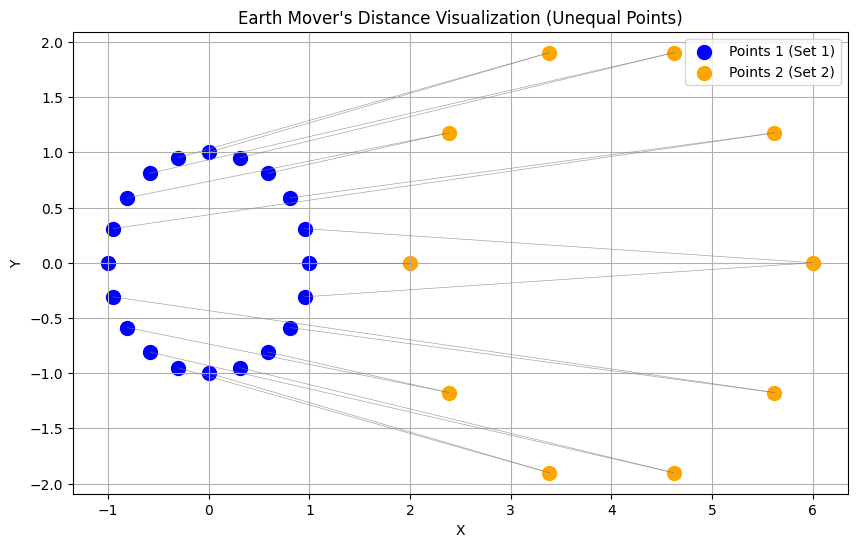

Earth Mover's Distance (EMD): 4.064892983573278


In [46]:
# Define points
circle1_points = [(np.cos(t), np.sin(t)) for t in np.linspace(0, 2 * np.pi, 20, endpoint=False)]
circle2_points = [(4 + 2 * np.cos(t), 2 * np.sin(t)) for t in np.linspace(0, 2 * np.pi, 10, endpoint=False)]  # Fewer points

# Calculate EMD
emd_value = calculate_emd(circle1_points, circle2_points)
print("Earth Mover's Distance (EMD):", emd_value)
